In [ ]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import requests
import os
from PIL import Image
from typing import Dict, List, Tuple
import zipfile
import pathlib

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Practice Exercises

#### Creating Pizza_Steak_Sushi folder

In [ ]:
data_path = pathlib.Path('model')
img_path = data_path/'pizza_steak_sushi'

if img_path.is_dir():
  print(f"{img_path} already exists")
else:
  print(f"Creating {img_path}")
  img_path.mkdir(parents=True, exist_ok=True)

Creating model/pizza_steak_sushi


#### Creating a ZipFile Folder and downloading the dataset into that folder

In [ ]:
zip_path = data_path/'pizza_steak_sushi.zip'

if zip_path.is_dir():
  print(f"{zip_path} already exists, skipping download")
else:
  print(f"Downloading {zip_path}...")
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  with open(zip_path, 'wb') as f:
    f.write(request.content)



#### Extracting all the data inside the zipfile into the Pizza_Steak_Sushi folder

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  print(f"Extracting the data into pizza_steak_sushi")
  zip_ref.extractall(img_path)


Extracting the data into pizza_steak_sushi


In [ ]:

def os_walk_through(dir_path):
  for direpaths, direnames, filenames in os.walk(dir_path):
    print(f"There are {len(direnames)} directories and {len(filenames)} images in {direpaths}.")

os_walk_through(img_path)

There are 2 directories and 0 images in model/pizza_steak_sushi.
There are 3 directories and 0 images in model/pizza_steak_sushi/test.
There are 0 directories and 31 images in model/pizza_steak_sushi/test/sushi.
There are 0 directories and 19 images in model/pizza_steak_sushi/test/steak.
There are 0 directories and 25 images in model/pizza_steak_sushi/test/pizza.
There are 3 directories and 0 images in model/pizza_steak_sushi/train.
There are 0 directories and 72 images in model/pizza_steak_sushi/train/sushi.
There are 0 directories and 75 images in model/pizza_steak_sushi/train/steak.
There are 0 directories and 78 images in model/pizza_steak_sushi/train/pizza.


#### Creating train and test directoties path

In [ ]:
train_dir = img_path/'train'
test_dir = img_path/'test'

#### Creating a transform pipeline

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

#### Creating training and testing datasets

In [ ]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform,
                                 target_transform = None)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: model/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

### Exercise # 1

#### Creating training and testing dataloaders

In [ ]:
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 32,
                              shuffle = True,
                              num_workers= os.cpu_count())

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = 32,
                              shuffle = False,
                              num_workers= os.cpu_count())

In [ ]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Exercise # 2

#### Creating tinyVGG Model class

In [ ]:
class tinyVGGModel(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units,
                  kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.block3 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.linear_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units*64, out_features = output_shape)
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.linear_layer(x)
    return x


In [ ]:
model0 = tinyVGGModel(input_shape = 3, hidden_units =10 , output_shape = len(class_names)).to(device)
model0

tinyVGGModel(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Co

In [ ]:
rand_img = torch.randn(size=(3,64,64))
model0(rand_img.unsqueeze(dim=0).to(device))

tensor([[ 0.0216, -0.0136,  0.0413]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
def accuracy_score(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = correct/len(y_pred)
  return acc

### Exercise # 3

#### Creating training and testing functions

In [ ]:
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=None):

  trainLoss, trainAcc = 0,0
  for batch, (x_train,y_train) in enumerate(data_loader):
    x_train, y_train = x_train.to(device), y_train.to(device)
    model.train()
    train_preds = model(x_train)
    loss = loss_fn(train_preds, y_train)
    trainLoss += loss.item()
    trainAcc += accuracy_score(y_train, train_preds.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



  trainLoss /= len(data_loader)
  trainAcc /= len(data_loader)
  return trainLoss, trainAcc




In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=None):

  testLoss, testAcc = 0,0

  model.eval()
  with torch.inference_mode():
    for x_test,y_test in data_loader:
      x_test, y_test = x_test.to(device), y_test.to(device)
      test_preds = model(x_test)
      loss = loss_fn(test_preds, y_test)
      testLoss += loss.item()
      testAcc += accuracy_fn(y_test, test_preds.argmax(dim=1))

    testLoss /= len(data_loader)
    testAcc /= len(data_loader)
  return testLoss, testAcc


In [ ]:
lossFun = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params = model0.parameters(),
                         lr = 0.001)

In [ ]:
def train(model: torch.nn.Module,
          trainDataLoader: torch.utils.data.DataLoader,
          testDataLoader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          epochs:int,
          device: torch.device = None):

  results = {'Model_Name': model.__class__.__name__,
             'train_loss': [],
             'test_loss': [],
             'train_acc': [],
             'test_acc': []}

  for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model = model,
             data_loader = trainDataLoader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device= device)

    test_loss, test_acc = test_step(model = model,
             data_loader = testDataLoader,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn,
             device= device)

    print(f"Epoch: {epoch+1} | Train-Loss: {train_loss:4f} | Test-Loss: {test_loss:4f} | Train-Acc: {train_acc:2f}% | Test-Acc: {test_acc:2f}%")

    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)
  return results

In [ ]:
epoch5 = train(model = model0,
      trainDataLoader= train_dataloader,
      testDataLoader= test_dataloader,
      loss_fn = lossFun,
      optimizer= optim,
      accuracy_fn = accuracy_score,
      epochs = 5,
      device = device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train-Loss: 1.106017 | Test-Loss: 1.090332 | Train-Acc: 0.281250% | Test-Acc: 0.541667%
Epoch: 2 | Train-Loss: 1.100343 | Test-Loss: 1.100965 | Train-Acc: 0.234375% | Test-Acc: 0.197917%
Epoch: 3 | Train-Loss: 1.100534 | Test-Loss: 1.098562 | Train-Acc: 0.292969% | Test-Acc: 0.197917%
Epoch: 4 | Train-Loss: 1.097697 | Test-Loss: 1.098985 | Train-Acc: 0.433594% | Test-Acc: 0.260417%
Epoch: 5 | Train-Loss: 1.093639 | Test-Loss: 1.102745 | Train-Acc: 0.425781% | Test-Acc: 0.260417%


In [ ]:
epoch20 = train(model = model0,
      trainDataLoader= train_dataloader,
      testDataLoader= test_dataloader,
      loss_fn = lossFun,
      optimizer= optim,
      accuracy_fn = accuracy_score,
      epochs = 20,
      device = device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Train-Loss: 1.088278 | Test-Loss: 1.112658 | Train-Acc: 0.425781% | Test-Acc: 0.260417%
Epoch: 2 | Train-Loss: 1.117227 | Test-Loss: 1.101854 | Train-Acc: 0.304688% | Test-Acc: 0.260417%
Epoch: 3 | Train-Loss: 1.083024 | Test-Loss: 1.108257 | Train-Acc: 0.472656% | Test-Acc: 0.333333%
Epoch: 4 | Train-Loss: 1.076370 | Test-Loss: 1.108437 | Train-Acc: 0.593750% | Test-Acc: 0.354167%
Epoch: 5 | Train-Loss: 1.077419 | Test-Loss: 1.111993 | Train-Acc: 0.371094% | Test-Acc: 0.260417%
Epoch: 6 | Train-Loss: 1.057265 | Test-Loss: 1.097238 | Train-Acc: 0.449219% | Test-Acc: 0.312500%
Epoch: 7 | Train-Loss: 0.893912 | Test-Loss: 1.070717 | Train-Acc: 0.613281% | Test-Acc: 0.393939%
Epoch: 8 | Train-Loss: 0.858111 | Test-Loss: 1.037547 | Train-Acc: 0.667969% | Test-Acc: 0.464015%
Epoch: 9 | Train-Loss: 0.886864 | Test-Loss: 1.378318 | Train-Acc: 0.660156% | Test-Acc: 0.302083%
Epoch: 10 | Train-Loss: 0.940758 | Test-Loss: 0.986428 | Train-Acc: 0.636719% | Test-Acc: 0.524621%
Epoch: 11

In [ ]:
epoch50 = train(model = model0,
      trainDataLoader= train_dataloader,
      testDataLoader= test_dataloader,
      loss_fn = lossFun,
      optimizer= optim,
      accuracy_fn = accuracy_score,
      epochs = 50,
      device = device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Train-Loss: 0.930407 | Test-Loss: 0.986480 | Train-Acc: 0.570312% | Test-Acc: 0.515152%
Epoch: 2 | Train-Loss: 0.810296 | Test-Loss: 0.993219 | Train-Acc: 0.574219% | Test-Acc: 0.484848%
Epoch: 3 | Train-Loss: 0.891616 | Test-Loss: 0.982690 | Train-Acc: 0.542969% | Test-Acc: 0.505682%
Epoch: 4 | Train-Loss: 0.802105 | Test-Loss: 1.006871 | Train-Acc: 0.675781% | Test-Acc: 0.506629%
Epoch: 5 | Train-Loss: 0.856114 | Test-Loss: 0.937523 | Train-Acc: 0.539062% | Test-Acc: 0.557765%
Epoch: 6 | Train-Loss: 0.806302 | Test-Loss: 0.909963 | Train-Acc: 0.679688% | Test-Acc: 0.535038%
Epoch: 7 | Train-Loss: 0.783551 | Test-Loss: 1.066694 | Train-Acc: 0.601562% | Test-Acc: 0.434659%
Epoch: 8 | Train-Loss: 0.737104 | Test-Loss: 0.959241 | Train-Acc: 0.691406% | Test-Acc: 0.517045%
Epoch: 9 | Train-Loss: 0.869744 | Test-Loss: 0.950155 | Train-Acc: 0.605469% | Test-Acc: 0.506629%
Epoch: 10 | Train-Loss: 0.769233 | Test-Loss: 0.970363 | Train-Acc: 0.582031% | Test-Acc: 0.464962%
Epoch: 11

In [ ]:
import pandas as pd

df1 = pd.DataFrame(epoch5)
df2 = pd.DataFrame(epoch20)
df3 = pd.DataFrame(epoch50)


In [ ]:
def plot_loss_curves(result1: Dict[str, List[float]], result2: Dict[str, List[float]], result3: Dict[str, List[float]]):

  train_loss1 = result1['train_loss']
  test_loss1 = result1['test_loss']
  train_acc1 = result1['train_acc']
  test_acc1 = result1['test_acc']

  train_loss2 = result2['train_loss']
  test_loss2 = result2['test_loss']
  train_acc2 = result2['train_acc']
  test_acc2 = result2['test_acc']

  train_loss3 = result3['train_loss']
  test_loss3 = result3['test_loss']
  train_acc3 = result3['train_acc']
  test_acc3 = result3['test_acc']

  epochs1 = range(len(result1['train_loss']))
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(epochs1, train_loss1, label='train-loss-5')
  plt.plot(epochs1, test_loss1, label = 'test_loss-5')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs1, train_acc1, label='train-acc-5')
  plt.plot(epochs1, test_acc1, label = 'test_acc-5')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

  epochs2 = range(len(result2['train_loss']))
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(epochs2, train_loss2, label='train-loss-20')
  plt.plot(epochs2, test_loss2, label = 'test_loss-20')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs2, train_acc2, label='train-acc-20')
  plt.plot(epochs2, test_acc2, label = 'test_acc-20')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

  epochs3 = range(len(result3['train_loss']))
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(epochs3, train_loss3, label='train-loss-50')
  plt.plot(epochs3, test_loss3, label = 'test_loss-50')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs3, train_acc3, label='train-acc-50')
  plt.plot(epochs3, test_acc3, label = 'test_acc-50')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.show()

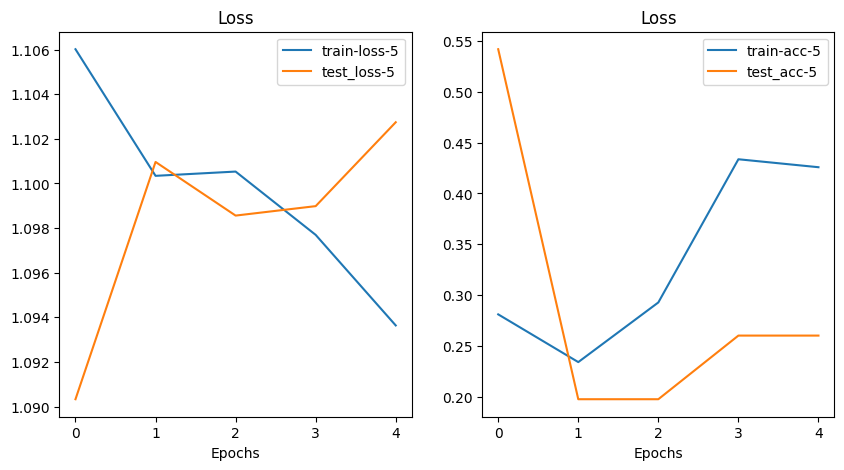

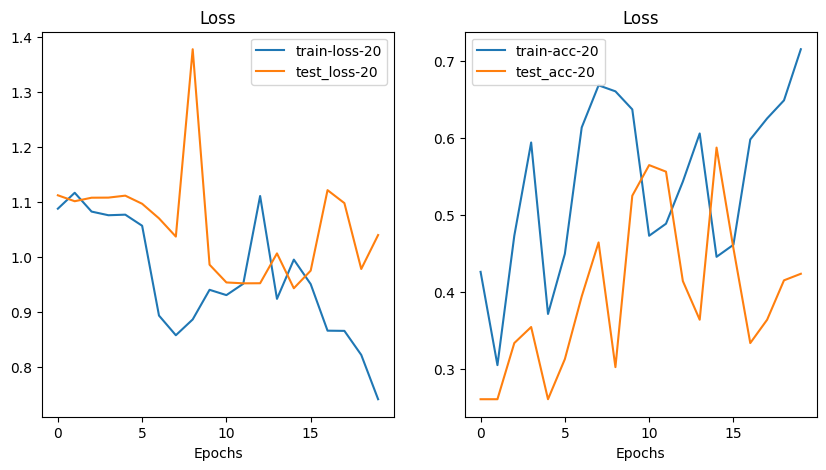

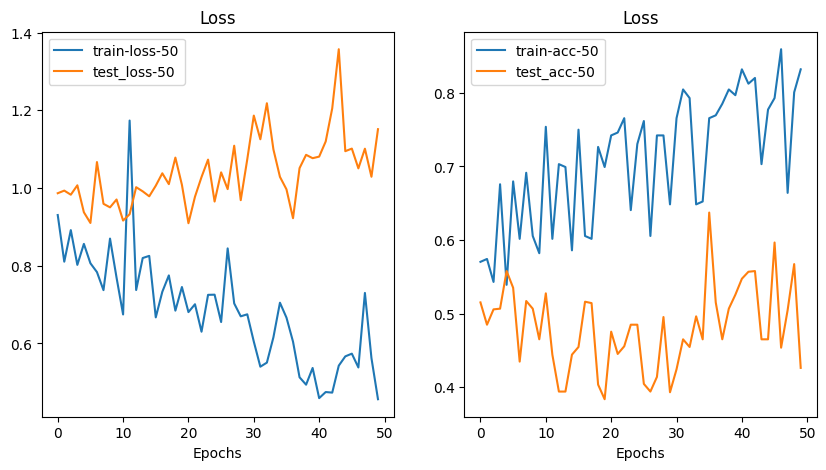

In [ ]:
plot_loss_curves(epoch5, epoch20, epoch50)

In [ ]:
import torchvision

def pred_plot(model: torch.nn.Module,
              image_path: str,
              class_names: List[str]= None,
              transform = None,
              device=device):

  target_img = torchvision.io.read_image(str(img_path)).type(torch.float32)/255.0
  model.to(device)
  if transform:
    target_img = transform(target_img)

  model.eval()
  with torch.inference_mode():
    target_img = target_img.unsqueeze(dim=0)
    y_pred = model(target_img.to(device))
    pred_probs = torch.softmax(y_pred, dim=1).to(device)
    pred_labels = pred_probs.argmax(dim=1)

  plt.imshow(target_img.squeeze(dim=0).permute(1,2,0))

  if class_names:
    title = f"pred: {class_names[pred_labels.cpu()]} pred-probs: {pred_probs.max().cpu():.2f}"
  else:
    title = f"pred: {pred_labels.cpu()} pred-probs: {pred_probs.max().cpu():.2f}"

  plt.title(title)
  plt.show()